In [1]:
#Diabetic Retinopathy Detection

In [2]:
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [5]:
# Add an additional column, mapping to the type
df = pd.read_csv(r"C:\Users\rk239\Desktop\POJECTS\PROJECT 5TH SEM\Data Sources\Diabetic Retinopathy 224x224 Gaussian Filtered\train.csv")

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

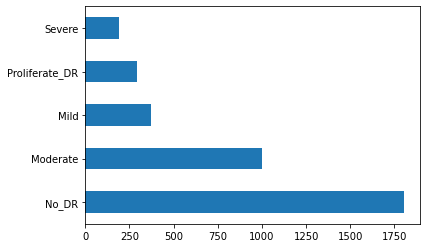

In [6]:
df['type'].value_counts().plot(kind='barh')


<AxesSubplot:>

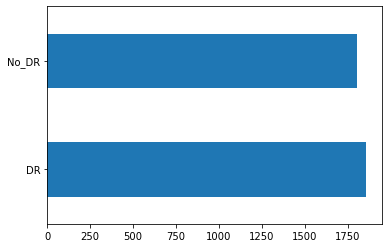

In [7]:
df['binary_type'].value_counts().plot(kind='barh')


In [8]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), r"C:\Users\rk239\Desktop\PROJECT 5TH SEM\Result\train")
print(val['type'].value_counts(), r"C:\Users\rk239\Desktop\PROJECT 5TH SEM\Result\val")
print(test['type'].value_counts(), r"C:\Users\rk239\Desktop\PROJECT 5TH SEM\Result\test")


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 C:\Users\rk239\Desktop\PROJECT 5TH SEM\Result\train
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 C:\Users\rk239\Desktop\PROJECT 5TH SEM\Result\val
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 C:\Users\rk239\Desktop\PROJECT 5TH SEM\Result\test


In [9]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [10]:
# Copy images to respective working directory
src_dir = r"C:\Users\rk239\Desktop\POJECTS\PROJECT 5TH SEM\Data Sources\Diabetic Retinopathy 224x224 Gaussian Filtered\gaussian_filtered_images\gaussian_filtered_images"
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
    
for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rk239\\Desktop\\PROJECT 5TH SEM\\Data Sources\\Diabetic Retinopathy 224x224 Gaussian Filtered\\gaussian_filtered_images\\gaussian_filtered_images\\No_DR\\0b2ea8f268cf.png'

In [13]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [14]:
#Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
81/81 [==============================] - 64s 772ms/step - loss: 0.4532 - acc: 0.8025 - val_loss: 0.7033 - val_acc: 0.5073
Epoch 2/30
81/81 [==============================] - 49s 598ms/step - loss: 0.2896 - acc: 0.8794 - val_loss: 0.7012 - val_acc: 0.5073
Epoch 3/30
81/81 [==============================] - 40s 488ms/step - loss: 0.2457 - acc: 0.9028 - val_loss: 0.6181 - val_acc: 0.5927
Epoch 4/30
81/81 [==============================] - 30s 363ms/step - loss: 0.2296 - acc: 0.9176 - val_loss: 0.4619 - val_acc: 0.8818
Epoch 5/30
81/81 [==============================] - 29s 354ms/step - loss: 0.2018 - acc: 0.9274 - val_loss: 0.3660 - val_acc: 0.8800
Epoch 6/30
81/81 [==============================] - 31s 377ms/step - loss: 0.1871 - acc: 0.9309 - val_loss: 0.2931 - val_acc: 0.8782
Epoch 7/30
81/81 [==============================] - 32s 394ms/step - loss: 0.1761 - acc: 0.9352 - val_loss: 0.2729 - val_acc: 0.8782
Epoch 8/30
81/81 [==============================] - 33s 403ms/step - 

In [15]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [16]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
##print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 [==============================] - 5s 272ms/step - loss: 0.1769 - acc: 0.9382
Accuracy:  0.9381818175315857


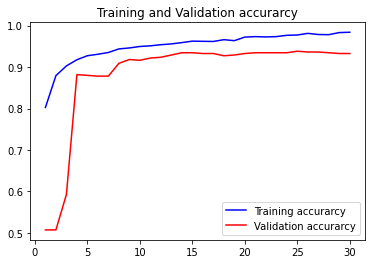

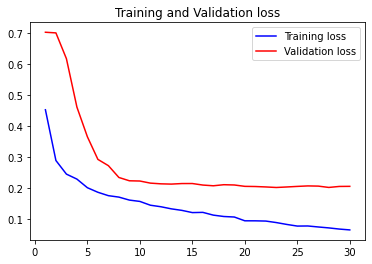

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [26]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')         

No DR


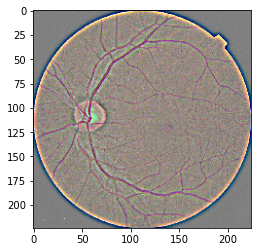

In [28]:
predict_class(r"C:\Users\rk239\Desktop\PROJECT 5TH SEM\Data Sources\Diabetic Retinopathy 224x224 Gaussian Filtered\gaussian_filtered_images\gaussian_filtered_images\No_DR\fed5bb685832.png")